# Customer Support on Twitter

Author: Ramy Ghorayeb
    
Access the competition and download the dataset [here](https://www.kaggle.com/thoughtvector/customer-support-on-twitter#sample.csv)

## Data Exploration

### Sample discovery

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
sample = pd.read_csv('data/sample.csv')

In [3]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 7 columns):
tweet_id                   93 non-null int64
author_id                  93 non-null object
inbound                    93 non-null bool
created_at                 93 non-null object
text                       93 non-null object
response_tweet_id          65 non-null object
in_response_to_tweet_id    68 non-null float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 4.5+ KB


In [18]:
sample.loc[:5]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,@105835 Your business means a lot to us. Pleas...,NaN,119239.0
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm su...,119238,NaN
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,@105836 LiveChat is online at the moment - htt...,119241,119242.0
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've...,119243,119240.0
5,119243,VirginTrains,False,Tue Oct 10 15:25:14 +0000 2017,"@105836 Have you tried from another device, Mi...",119244,119241.0


In [19]:
for i in sample.loc[:5][['author_id','text']].iterrows():
    print('# Author :',i[1][0],'--',i[1][1])

# Author : 105834 -- @AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard is opened😡😡😡
# Author : ChaseSupport -- @105835 Your business means a lot to us. Please DM your name, zip code and additional details about your concern. ^RR https://t.co/znUu1VJn9r
# Author : 105835 -- @76328 I really hope you all change but I'm sure you won't! Because you don't have to!
# Author : VirginTrains -- @105836 LiveChat is online at the moment - https://t.co/SY94VtU8Kq or contact 03331 031 031 option 1, 4, 3 (Leave a message) to request a call back
# Author : 105836 -- @VirginTrains see attached error message. I've tried leaving a voicemail several times in the past week https://t.co/NxVZjlYx1k
# Author : VirginTrains -- @105836 Have you tried from another device, Miriam ^MM


### Dataset Exploration

In [4]:
data = pd.read_csv('data/twcs.zip', compression='zip')

In [5]:
companies = data[data['author_id'].apply(lambda x:not x.isdigit())]

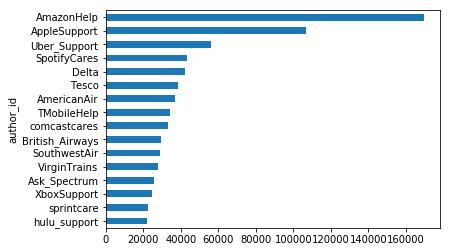

In [6]:
companies_count = companies.groupby(['author_id']).count()

companies_count[companies_count['tweet_id']>20000]['tweet_id'].sort_values().plot(kind='barh')

Let's focus on AmazonHelp customer support for this exercise

In [343]:
# Get only AmazonHelp related tweets

data_am_supp = data[data['author_id']=='AmazonHelp']
data_am_cust = data[data['text'].str.contains('@AmazonHelp')][data['author_id']!='AmazonHelp']

data_am = data_am_supp.merge(data_am_cust,how='outer')

data_am.to_csv('data/data_AmazonHelp.csv',index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


### AmazonHelp customer

**Emoji analysis**

In [227]:
data_am = pd.read_csv('data/data_AmazonHelp.csv')
data_am_cust = data[data['text'].str.contains('@AmazonHelp')][data['author_id']!='AmazonHelp']

In [284]:
bool_am_emo = [len(list( set(i[1][4]) & set(emoji.UNICODE_EMOJI.keys()) ))>0
               for i in progressbar.progressbar(data_am_cust.iterrows())]

data_am_cust[bool_am_emo].to_csv('data/data_AmazonHelp_withEmojis.csv')


| | #                                            | 134732 Elapsed Time: 0:00:36


In [221]:
data_am_cust = pd.read_csv('data/data_AmazonHelp_withEmojis.csv')

In [287]:
def emoji_count(data,filter_company):
    count = {}
    for s in data[data['author_id']!=filter_company]['text']:
        for c in list(s):
            if c in emoji.UNICODE_EMOJI.keys():
                if c not in count.keys():
                    count[c] = 1
                else:
                    count[c] += 1
    return count

In [288]:
count_emoji = emoji_count(data_am_cust[bool_am_emo],filter_company='AmazonHelp')
list_emoji = [list(i) for i in count_emoji.items()]
list_emoji.sort(key=lambda x:x[1], reverse=True)
list_emoji = np.array(list_emoji)

[['😡' '1051']
 ['😂' '1020']
 ['😊' '622']
 ['👍' '609']
 ['🤔' '472']
 ['❤' '414']
 ['😍' '411']
 ['😭' '392']
 ['🙄' '346']
 ['😉' '315']]


<BarContainer object of 10 artists>

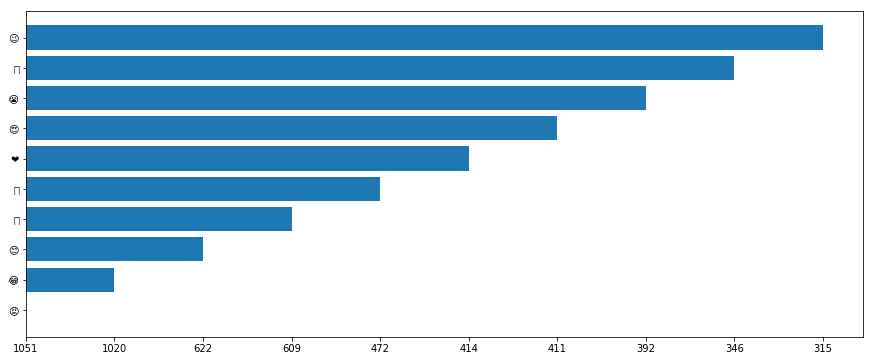

In [308]:
print(list_emoji[:10])

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.barh(list_emoji[:10].T[0],list_emoji[:10].T[1])

Aside from the complains (ordinary for a customer support), if not sarcasm, amazon seems like a funny company!

To start digging into the data, let's do a sentiment analysis on the tweets.

**Sentiment analysis preprocessing: filter language**

In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data_am = pd.read_csv('data/data_AmazonHelp.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# We turn tweets with no language to english

from langdetect import detect
import time
import progressbar

def lang_detection(data_am):
    print('dataset size: ',len(data_am))
    lang = pd.DataFrame(columns=['tweet_id','language'])
    
    for elmt in progressbar.progressbar(data_am.iterrows()):
        try:
            lang = lang.append({'tweet_id':elmt[1][1],'language':detect(elmt[1][5])},ignore_index=True)
        except:
            lang = lang.append({'tweet_id':elmt[1][1],'language':'universal'},ignore_index=True)
    return lang

In [ ]:
lang = lang_detection(data_am)
data_am = data_am.merge(lang, how='inner',on='tweet_id')
data_am.to_csv('data/data_AmazonHelp_lang.csv',index=False)

dataset size:  615585


| |  #                                           | 615584 Elapsed Time: 7:44:44


In [9]:
# Filter to English only
data_am = pd.read_csv('data/data_AmazonHelp_lang.csv')
data_am = data_am[data_am['language'].isin(['en','universal'])]
data_am.to_csv('data/data_AmazonHelp_en.csv',index=False)

The data is not labelled so we cannot do any supervised model on it right now. Let's roughly use the emojis to classify the data between positive and negative comment and use it as training labelled data.

**Sentiment analysis preprocessing: create training dataset for supervised classification**

In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data_am = pd.read_csv('data/data_AmazonHelp_en.csv')
data_am = data_am.drop(['language','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)


In [11]:
import emoji

def has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

In [12]:
#filter comments with emojis
data_am['emoji'] = data_am['text'].apply(lambda x:has_emoji(x))
data_emo = data_am[data_am['emoji'] == True]
data_emo = data_emo.drop('emoji',axis=1)

In [13]:
# positive or negative

def sent_emoj(text):
    pos = '😀,😁,😃,😄,😊,😋,😎,😍,😘,🥰,😗,😙,😚,☺️,🙂,🤗,🤩,😌,🤤,🥳,💫,⭐️,☀️,🌞,🌝,🏆,🥇,❤️,🧡,💛,💚,💙,💜,🖤,❣️,💕,💞,💓,💗,💖,💘,💝,💟,💯,🎵,🎶,👍,🎀,🎊,🎉'.split(',')
    neg = '🤔,🤨,😐,😑,😶,🙄,😣,😥,🤐,😪,😫,😴,😒,😓,😔,😕,☹️,🙁,😖,😞,😟,😤,😢,😭,😦,😧,😨,😩,🤯,😰,😱,🥵,🥶,😳,😵,😡,😠,🤬,😷,🤒,🤕,🤢,🤮,🤧,🤥,👿,💀,💩,🖕,👎,🌪,🌧,⛈,🌩,💣,🔪,⚰️,❌,⛔️,📛,🚫,⁉️'.split(',')    
    sentiment = 0
    for character in text:
        if character in pos:
            sentiment+=1
        if character in neg:
            sentiment-=1
    if sentiment>0:
        return 1
    if sentiment<0:
        return -1
    if sentiment==0:
        return 0

In [14]:
data_emo['sentiment'] = data_am['text'].apply(lambda x:sent_emoj(x))
data_emo.to_csv('data/data_AmazonHelp_en_emoj.csv',index=False)

In [363]:
print('size of the labelled dataset: ',len(data_emo))

size of the labelled dataset:  87


That's not enough data. We will need to use an out-of-the-box solution or do transfer learning if we want to build a model.

**Sentiment analysis using VADER**

In [449]:
import math
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()
data_emo['vader_sentiment'] = data_emo.text.apply(lambda x:round(sentiment.polarity_scores(x)['compound']))

In [455]:
for i in data_emo[data_emo['vader_sentiment'] != data_emo['sentiment']].iterrows():
    print('# sentiment by emoji: ',i[1][7],', by vader: ',i[1][8],'\n',i[1][4])

# sentiment by emoji:  0 , by vader:  1 
 @117091 We know not having service is ruff, but dogs make everything better! 🐶  ^HM
# sentiment by emoji:  0 , by vader:  1 
 @120467 Thank you for showing the interest towards our device. Good things come to those who wait. 😇 (1/2)^HR
# sentiment by emoji:  1 , by vader:  0 
 @122516 You're welcome!😁 ^AX
# sentiment by emoji:  1 , by vader:  0 
 @125704 😆👍💕
# sentiment by emoji:  1 , by vader:  0 
 @130298 Que lindooooooo o box do Sherlock Holmes! 😍📚 ^JJ
# sentiment by emoji:  1 , by vader:  0 
 @133294 😄😄
# sentiment by emoji:  1 , by vader:  -1 
 @133889 No worries at all, Fenestro. If you ever have any further questions, you know where to find us 😊^SM
# sentiment by emoji:  1 , by vader:  0 
 @133898 Hi, payment isn't taken until the order has been dispatched. So there is no need to worry 🙂 ^KI
# sentiment by emoji:  1 , by vader:  -1 
 @133914 No problem at all! We have your back! 👍 ^KI
# sentiment by emoji:  1 , by vader:  0 
 @134499 Hi 

In [456]:
from sklearn.metrics import accuracy_score
y_true = data_emo['sentiment']
y_pred = data_emo['vader_sentiment']
accuracy_score(y_true,y_pred)

0.6896551724137931

Looking at the results, most of differences between vader and the emoji classifier are on our classifier's fault, so the accuracy's results are not that worrying.

In [466]:
data_am['vader_sentiment'] = data_am.text.apply(lambda x:sentiment.polarity_scores(x)['compound'])

data_am.to_csv('data/data_AmazonHelp_en_vadersent.csv',index=False)


**Topic Vizualisation**